In [1]:
%matplotlib inline

In [2]:
import xray 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

In [3]:
Dam_info = pd.read_csv('/raid/yifan/Reservoir_modeling/Run_reservoir/reservoir_to_model_maxFlowFromRVIC_exceed0.2.csv')

In [4]:
Dam_info

,dam_number,dam_name,xls_name,output_name,dam_lat,dam_lon,grid_lat,grid_lon,year_operated_start_of_Calendar_year,top_vol_acre_feet,bot_vol_acre_feet,max_flow_cfs,min_flow_cfs
0,1,Watauga,watauga,Watauga,36.3233,-82.1219,36.3125,-82.0625,1949,677000,0,1132.7,107
1,2,South Holston,southholston,South_Holston,36.5233,-82.0889,36.5625,-82.0625,1951,764000,0,1246.0,90
2,3,Boone,boone,Boone,36.4400,-82.4378,36.4375,-82.4375,1953,193400,0,3998.4,400
3,5,Cherokee,cherokee,Cherokee,36.1661,-83.4983,36.1875,-83.4375,1942,1541000,0,7328.4,325
4,7,Douglas,douglas,Douglas,35.9611,-83.5389,35.9375,-83.4375,1943,1461000,0,11029.2,585
5,8,Fort Loudoun,fortloudoun,Fort_Loudoun,35.7909,-84.2427,35.8125,-84.1875,1943,393000,0,22085.9,710
6,11,Fontana,fontana,Fontana,35.4522,-83.8047,35.4375,-83.8125,1945,1443000,0,6151.8,790
7,16,Tellico,tellico,Tellico,35.7778,-84.2597,35.6875,-84.3125,1980,424000,0,8983.3,1000
8,17,Norris,norris,Norris,36.2242,-84.0914,36.1875,-84.0625,1936,2552000,0,6867.0,200
9,18,Watts Bar,wattsbar,Watts_Bar,35.6213,-84.7816,35.5625,-84.8125,1942,1175000,0,44998.9,1200


TypeError: unsupported operand type(s) for /: 'list' and 'int'

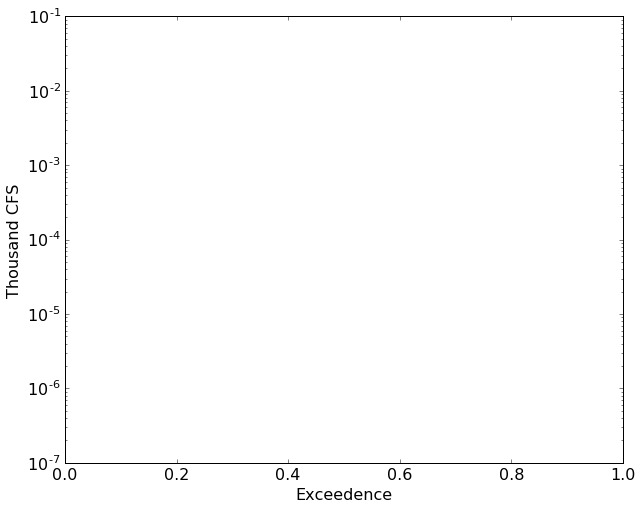

In [5]:
#for i in range(len(Dam_info['dam_name'])):
#for i in [0,1,2,3,4,5,6,8,9,10,11,12,13,14,15,16,18,19,22]:
#for i in [13,14,15,16,18,19,22]:
for i in [4]:    
    #Define the period
    starting_year = max(Dam_info['year_operated_start_of_Calendar_year'][i],1949)+1
    end_year = 2010
    starting_time = str(starting_year)+'-10-01 12:00:00' #This is the start of water year----starting_year+1
    end_time = str(end_year)+'-09-30 12:00:00'
    starting_date = str(starting_year)+'-10-01 00:00:00' #This is the start of water year----starting_year+1
    end_date = str(end_year)+'-09-30 00:00:00'
    time_index = pd.date_range(start = starting_time,end = end_time ,freq='D')
    #read in modeled streamflow using new guide curve -- median of daily data (regulated)
    Raw_model = xray.open_dataset('/raid/yifan/Reservoir_modeling/Run_reservoir/result_new_guide_curve.modified_flow.nc')

    #read in observed stream flow from TVA(unregulated)
    filename_latlon = str(Dam_info['grid_lat'][i])+'_'+str(Dam_info['grid_lon'][i])+'.daily.1903_2013'
    dir_latlon = '/raid2/ymao/VIC_RBM_east_RIPS/data/TVA_data/naturalized_flow/downscaled_daily_flow/latlon/'+filename_latlon
    Nflow_TVA = pd.read_csv(dir_latlon,sep=' ',header=None,parse_dates=[[0,1,2]])
    Nflow_TVA.rename(columns={'0_1_2': 'Time', 3: 'flow(cfs)'}, inplace=True)
    Nflow_TVA = Nflow_TVA.set_index('Time')
    Nflow_TVA = Nflow_TVA.ix[starting_date:end_date]
    Natual_flow_TVA = Nflow_TVA.resample('1W',how = 'mean')['flow(cfs)']

    #read in TVA observed streamflow (regulated)
    xls_path = '/raid/yifan/Reservoir_modeling/TVA_reservoir_data/'+Dam_info['xls_name'][i]+'.xlsx'
    Raw = pd.ExcelFile(xls_path)
    Total_Q = Raw.parse(sheetname='TotalQ')
    year_start = Total_Q.columns[0]
    if Dam_info['year_operated_start_of_Calendar_year'][i] <= 1949:
        col_del = np.concatenate([np.arange(0,starting_year-year_start,1),np.arange(-1,end_year-2015-1,-1)])
    else:
        col_del = np.concatenate([np.arange(0,starting_year-year_start,1),np.arange(-1,end_year-2015-1,-1)])    
    Observed_temp = Total_Q.ix[1:367]#pd.concat([Total_Q.ix[1:60],Total_Q.ix[62:366]]).dropna(axis=1)
    Observed_Q = Observed_temp.drop(Observed_temp.columns[col_del],axis=1)#Observed_temp.resample('1w',how='mean')#groupby(Observed_temp.index.map(lambda t: t.week)).mean()
    temp = np.ravel(Observed_Q,'F')
    temp1 = temp[274:-92]
    temp2 = temp1[~np.isnan(temp1)]
    M = pd.DataFrame(temp2,index=Nflow_TVA.index)#Observed_Q.drop(Observed_Q.columns[col_del],axis=1)
    M = M.resample('1w',how='mean')
    #     M.iloc[10:12,M.shape[1]-1]=np.nan
    
    #read in modeled streamflow from RVIC (unregulated)
    RVIC = xray.open_dataset('/raid2/ymao/VIC_RBM_east_RIPS/RIPS/model_run/output/RVIC/Tennessee_8th_grid/hist/Tennessee_UH_1.hist_1949_2010.calibrated_1961_1970.rvic.h0a.2011-01-01.nc')
    RVIC = RVIC.isel(time=slice(0,-1))
    RVIC_flow = RVIC.sel(lat = Dam_info['grid_lat'][i],lon = Dam_info['grid_lon'][i])
    RVIC_flow = RVIC_flow.sel(time = time_index)
    Q = RVIC_flow.resample('1W','time',how = 'mean')
    
    #read in modeled streamflow using new guide curve -- median of daily data (regulated)
    Original_model = xray.open_dataset('/raid2/ymao/VIC_RBM_east_RIPS/RIPS/model_run/output/simple_reservoir/Tennessee/maxFlowFromRVIC_exceed0.2/Tennessee.modified_flow.nc')
    Original_streamflow = Original_model.sel(lat = Dam_info['grid_lat'][i],lon = Dam_info['grid_lon'][i])
    Raw_streamflow = Raw_model.sel(lat = Dam_info['grid_lat'][i],lon = Dam_info['grid_lon'][i])
    Model_Q = Raw_streamflow.sel(time = time_index)
    Original_Q = Original_streamflow.sel(time = time_index)
    L = Model_Q.resample('1W','time',how = 'mean')
    L_original = Original_Q.resample('1W','time',how = 'mean')

    #plot
    plt.figure(figsize=[10,8])
    plt.xlabel('Exceedence',fontsize=16)
    plt.ylabel('Thousand CFS',fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.yscale('log')

    f3, = plt.plot(np.arange(M.size)/M.size,sorted(M.values.ravel(),reverse=True),'k-',label='Observed Flow from TVA (regulated)',linewidth=2)
    f4, = plt.plot(np.arange(Natual_flow_TVA.shape[0])/Natual_flow_TVA.shape[0],sorted(Natual_flow_TVA,reverse=True)/,'k--',label='Observed naturalized flow from TVA (unregulated)')
    f5, = plt.plot(np.arange(Q.streamflow.values.size)/Q.streamflow.values.size,sorted(Q.streamflow.values*np.power(3.28,3),reverse=True),'r--',label='Modeled naturalized flow from RVIC (unregulated)')
    f1, = plt.plot(np.arange(L.streamflow.values.size)/L.streamflow.values.size,sorted(L.streamflow.values,reverse=True),'b-',label='Modeled flow using new guide curve (regulated)',linewidth=2)
    f2, = plt.plot(np.arange(L_original.streamflow.values.size)/L_original.streamflow.values.size,sorted(L_original.streamflow.values,reverse=True),'r-',label='Modeled flow using old guide curve (regulated)',linewidth=2)
    plt.legend(handles=[f1,f2,f3,f4,f5])
    water_year = '(water year:'+str(starting_year+1)+'-'+str(end_year)+')'
    title_name = 'Flow duration curve at Dam '+Dam_info['dam_name'][i]+'\n'
    plt.title(title_name+water_year,fontsize=20)
    output_path = '/raid/yifan/Reservoir_modeling/Analysis/fig_comparison_modeled_observed/Dam_'+Dam_info['output_name'][i]+'_flow_duration_curve.png'
    plt.savefig(output_path,dpi=300)
    print(i)

In [6]:
i = 4

In [7]:
#read in modeled streamflow using new guide curve -- median of daily data (regulated)
Raw_model = xray.open_dataset('/raid/yifan/Reservoir_modeling/Run_reservoir/result_new_guide_curve.modified_flow.nc')
    
    #read in observed stream flow from TVA(unregulated)
filename_latlon = str(Dam_info['grid_lat'][i])+'_'+str(Dam_info['grid_lon'][i])+'.daily.1903_2013'
dir_latlon = '/raid2/ymao/VIC_RBM_east_RIPS/data/TVA_data/naturalized_flow/downscaled_daily_flow/latlon/'+filename_latlon
Nflow_TVA = pd.read_csv(dir_latlon,sep=' ',header=None,parse_dates=[[0,1,2]])
Nflow_TVA.rename(columns={'0_1_2': 'Time', 3: 'flow(cfs)'}, inplace=True)
Nflow_TVA = Nflow_TVA.set_index('Time')
Nflow_TVA = Nflow_TVA.ix[starting_date:end_date]
Natual_flow_TVA = Nflow_TVA.resample('1W',how = 'mean')['flow(cfs)']

In [8]:
#for i in range(len(Dam_info['dam_name'])):
#for i in [0,1,2,3,4,5,6,8,9,10,11,12,13,14,15,16,18,19,22]:

    
    #read in TVA observed streamflow (regulated)
xls_path = '/raid/yifan/Reservoir_modeling/TVA_reservoir_data/'+Dam_info['xls_name'][i]+'.xlsx'
Raw = pd.ExcelFile(xls_path)
Total_Q = Raw.parse(sheetname='TotalQ')
year_start = Total_Q.columns[0]
if Dam_info['year_operated_start_of_Calendar_year'][i] <= 1949:
    col_del = np.concatenate([np.arange(0,starting_year-year_start,1),np.arange(-1,end_year-2015-1,-1)])
else:
    col_del = np.concatenate([np.arange(0,starting_year-year_start,1),np.arange(-1,end_year-2015-1,-1)])    
Observed_temp = Total_Q.ix[1:367]#pd.concat([Total_Q.ix[1:60],Total_Q.ix[62:366]]).dropna(axis=1)
Observed_Q = Observed_temp.drop(Observed_temp.columns[col_del],axis=1)#Observed_temp.resample('1w',how='mean')#groupby(Observed_temp.index.map(lambda t: t.week)).mean()
temp = np.ravel(Observed_Q,'F')
temp1 = temp[274:-92]
temp2 = temp1[~np.isnan(temp1)]
M = pd.DataFrame(temp2,index=Nflow_TVA.index)#Observed_Q.drop(Observed_Q.columns[col_del],axis=1)
M = M.resample('1w',how='mean')
#     M.iloc[10:12,M.shape[1]-1]=np.nan
    


In [9]:
#read in modeled streamflow from RVIC (unregulated)
RVIC = xray.open_dataset('/raid2/ymao/VIC_RBM_east_RIPS/RIPS/model_run/output/RVIC/Tennessee_8th_grid/hist/Tennessee_UH_1.hist_1949_2010.calibrated_1961_1970.rvic.h0a.2011-01-01.nc')
RVIC = RVIC.isel(time=slice(0,-1))
RVIC_flow = RVIC.sel(lat = Dam_info['grid_lat'][i],lon = Dam_info['grid_lon'][i])
RVIC_flow = RVIC_flow.sel(time = time_index)
Q = RVIC_flow.resample('1W','time',how = 'mean')

In [10]:
#read in modeled streamflow using new guide curve -- median of daily data (regulated)
Original_model = xray.open_dataset('/raid2/ymao/VIC_RBM_east_RIPS/RIPS/model_run/output/simple_reservoir/Tennessee/maxFlowFromRVIC_exceed0.2/Tennessee.modified_flow.nc')
Original_streamflow = Original_model.sel(lat = Dam_info['grid_lat'][i],lon = Dam_info['grid_lon'][i])
Raw_streamflow = Raw_model.sel(lat = Dam_info['grid_lat'][i],lon = Dam_info['grid_lon'][i])
Model_Q = Raw_streamflow.sel(time = time_index)
Original_Q = Original_streamflow.sel(time = time_index)
L = Model_Q.resample('1W','time',how = 'mean')
L_original = Original_Q.resample('1W','time',how = 'mean')

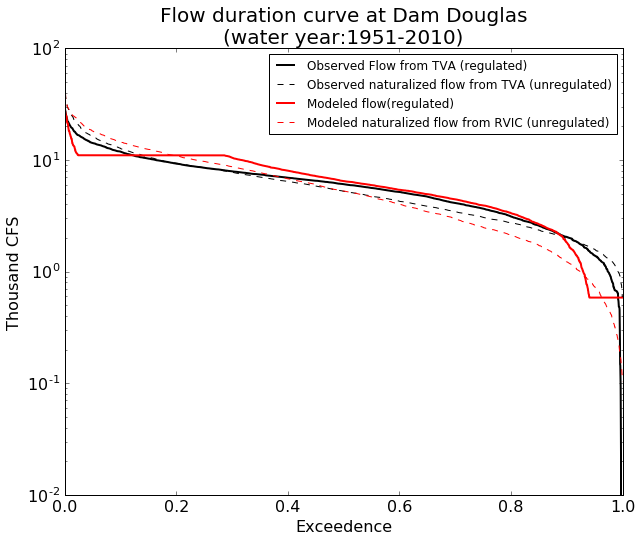

In [20]:
plt.figure(figsize=[10,8])
plt.xlabel('Exceedence',fontsize=16)
plt.ylabel('Thousand CFS',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.yscale('log')

f3, = plt.plot(np.arange(M.size)/M.size,sorted(M.values.ravel()/1000,reverse=True),'k-',label='Observed Flow from TVA (regulated)',linewidth=2)
f4, = plt.plot(np.arange(Natual_flow_TVA.shape[0])/Natual_flow_TVA.shape[0],sorted(Natual_flow_TVA/1000,reverse=True),'k--',label='Observed naturalized flow from TVA (unregulated)')
f5, = plt.plot(np.arange(Q.streamflow.values.size)/Q.streamflow.values.size,sorted(Q.streamflow.values*np.power(3.28,3)/1000,reverse=True),'r--',label='Modeled naturalized flow from RVIC (unregulated)')
f1, = plt.plot(np.arange(L.streamflow.values.size)/L.streamflow.values.size,sorted(L.streamflow.values/1000,reverse=True),'r-',label='Modeled flow(regulated)',linewidth=2)
#f2, = plt.plot(np.arange(L_original.streamflow.values.size)/L_original.streamflow.values.size,sorted(L_original.streamflow.values/1000,reverse=True),'r-',label='Modeled flow using old guide curve (regulated)',linewidth=2)
plt.legend(handles=[f3,f4,f1,f5])

water_year = '(water year:'+str(starting_year+1)+'-'+str(end_year)+')'
title_name = 'Flow duration curve at Dam '+Dam_info['dam_name'][i]+'\n'
plt.title(title_name+water_year,fontsize=20)
output_path = '/raid/yifan/Reservoir_modeling/Analysis/conference_feb_2016/Dam_'+Dam_info['output_name'][i]+'_flow_duration_curve_simplified.png'
plt.savefig(output_path,dpi=300,bbox_inches = 'tight')

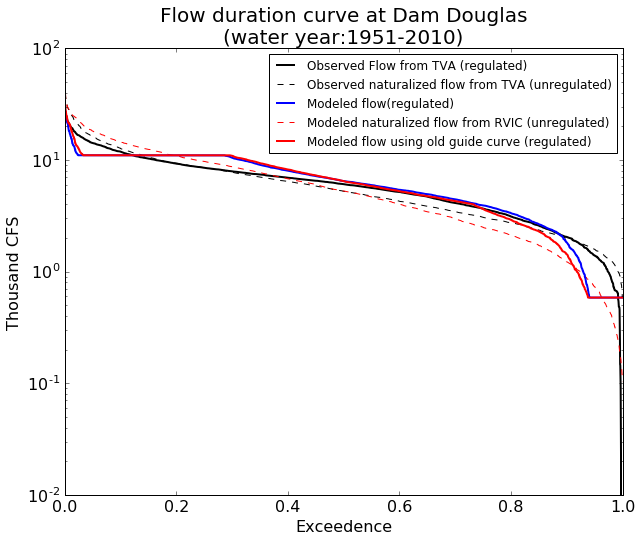

In [21]:
plt.figure(figsize=[10,8])
plt.xlabel('Exceedence',fontsize=16)
plt.ylabel('Thousand CFS',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.yscale('log')

f3, = plt.plot(np.arange(M.size)/M.size,sorted(M.values.ravel()/1000,reverse=True),'k-',label='Observed Flow from TVA (regulated)',linewidth=2)
f4, = plt.plot(np.arange(Natual_flow_TVA.shape[0])/Natual_flow_TVA.shape[0],sorted(Natual_flow_TVA/1000,reverse=True),'k--',label='Observed naturalized flow from TVA (unregulated)')
f5, = plt.plot(np.arange(Q.streamflow.values.size)/Q.streamflow.values.size,sorted(Q.streamflow.values*np.power(3.28,3)/1000,reverse=True),'r--',label='Modeled naturalized flow from RVIC (unregulated)')
f1, = plt.plot(np.arange(L.streamflow.values.size)/L.streamflow.values.size,sorted(L.streamflow.values/1000,reverse=True),'b-',label='Modeled flow(regulated)',linewidth=2)
f2, = plt.plot(np.arange(L_original.streamflow.values.size)/L_original.streamflow.values.size,sorted(L_original.streamflow.values/1000,reverse=True),'r-',label='Modeled flow using old guide curve (regulated)',linewidth=2)
plt.legend(handles=[f3,f4,f1,f5,f2])

water_year = '(water year:'+str(starting_year+1)+'-'+str(end_year)+')'
title_name = 'Flow duration curve at Dam '+Dam_info['dam_name'][i]+'\n'
plt.title(title_name+water_year,fontsize=20)
output_path = '/raid/yifan/Reservoir_modeling/Analysis/conference_feb_2016/Dam_'+Dam_info['output_name'][i]+'_flow_duration_curve.png'
plt.savefig(output_path,dpi=300,bbox_inches = 'tight')